# EDIPI Workshop qgs tutorial - Part II: Computing the full Lyapunov Spectrum

This notebook is the second one of a tutorial given during the EDIPI workshop at RMI in January 2023.
In this tutorial, you will learn:

1. How to install the [qgs](https://github.com/Climdyn/qgs) framework for low-order climate and weather modeling
2. How to run the model
3. How to compute the Largest Lyapunov Exponent (LLE) in the model
4. **How to compute the full Lyapunov Exponent spectrum**
5. How to compute the correlation properties of the underlying dynamical model

Here we will be concerned with task 4 above: learning how to compute the full [Lyapunov exponent](https://en.wikipedia.org/wiki/Lyapunov_exponent) spectrum in the model.

We assume that you have already been through the [Introduction notebook](https://github.com/jodemaey/EDIPI-qgs-tutorial-on-predictability/blob/main/EDIPI%20workshop%20qgs%20tutorial%20-%20Introduction.ipynb), qgs and the tutorial being installed.

## Setup of the model

We use again the simple 2-layer channel QG atmosphere truncated at wavenumber 2 on a beta-plane with a simple orography (a montain and a valley), as in the Introduction notebook. But now, we are going to use qgs [`lyapunov` toolbox](https://qgs.readthedocs.io/en/latest/files/technical/toolbox.html#lyapunov-module) to compute the full Lyapunov spectrum.

First, we need to load the model, and integrate it to find an initial condition on the attractor, as in the Introduction notebook:

### Modules import

First, load some modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Importing the model's modules

In [2]:
from qgs.params.params import QgParams
from qgs.integrators.integrator import RungeKuttaIntegrator, RungeKuttaTglsIntegrator
from qgs.functions.tendencies import create_tendencies
from qgs.plotting.util import std_plot

and diagnostics

In [3]:
from qgs.diagnostics.streamfunctions import MiddleAtmosphericStreamfunctionDiagnostic
from qgs.diagnostics.variables import VariablesDiagnostic
from qgs.diagnostics.multi import MultiDiagnostic

### Defining the model

First, we define some general parameters

In [4]:
# Time increment parameter
dt = 0.1
# Saving the model state every 5 steps
write_steps = 5

Now we create the model parameters object:

In [5]:
model_parameters = QgParams()

We set up some parameters:

In [6]:
# here we define the latitude to be 50 degrees and a predefined amplitude of the meridional temperature gradient
model_parameters.set_params({'phi0_npi': np.deg2rad(50.)/np.pi, 'hd':0.045})

and indicate that we want an atmospheric channel for the atmosphere, with Fourier modes up to wavenumber 2 in each spatial direction:

In [7]:
model_parameters.set_atmospheric_channel_fourier_modes(2, 2)

We also set some topography

In [8]:
model_parameters.ground_params.set_orography(0.2, 1)

and indicate the amplitude of the meridional temperature gradient which forces the model:

In [9]:
model_parameters.atemperature_params.set_thetas(0.1, 0)

and we are done configuring the model.

Finally, we create the tendencies $\boldsymbol{f}$ that will allow us to integrate the model equations:

In [10]:
%%time
f, Df = create_tendencies(model_parameters)

CPU times: user 6.5 s, sys: 764 ms, total: 7.27 s
Wall time: 6.47 s


### Time integration

We now integrate our model with the qgs built-in integrator:

In [11]:
integrator = RungeKuttaIntegrator()

We tell this integrator to use our defined model

In [12]:
integrator.set_func(f)

We can now start from a small random initial condition and integrate over a transient time to obtain an initial condition on the attractors

In [13]:
%%time
ic = np.random.rand(model_parameters.ndim)*0.1
integrator.integrate(0., 200000., dt, ic=ic, write_steps=0)  # write_steps=0 will only give us the last step
time, ic = integrator.get_trajectories()

CPU times: user 7.22 ms, sys: 25.8 ms, total: 33 ms
Wall time: 10.1 s


and we are ready to start our exercise on the computation of the full Lyapunov spectrum.

## Exercise: Computing the full spectrum

Use the [documentation](https://qgs.readthedocs.io/en/latest/files/technical/toolbox.html#lyapunov-module) and the [following example notebook](https://github.com/Climdyn/qgs/blob/master/notebooks/lyapunov/simple_model_lyapunov.ipynb) to help you write the code to compute the full spectrum.

In [14]:
from qgs.toolbox.lyapunov import LyapunovsEstimator

In [15]:
lvint = LyapunovsEstimator()

In [16]:
%%time

lvint.set_func(f, Df)
lvint.compute_lyapunovs(0., 10000., 20000., 0.1, 0.1, ic, write_steps=1)
btl, btraj, bexp, bvec = lvint.get_lyapunovs()

/scratch/jodemaey/projects/qgs_lyap_dev/qgs/toolbox/lyapunov.py:557: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  recorded_traj, recorded_exp, recorded_vec = _compute_backward_lyap_traj_jit(f, fjac, pretime, time, ttraj, mdt,
/scratch/jodemaey/projects/qgs_lyap_dev/qgs/toolbox/lyapunov.py:557: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  recorded_traj, recorded_exp, recorded_vec = _compute_backward_lyap_traj_jit(f, fjac, pretime, time, ttraj, mdt,
/scratch/jodemaey/projects/qgs_lyap_dev/qgs/toolbox/lyapunov.py:557: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  recorded_traj, recorded_exp, recorded_vec = _compute_backward_lyap_traj_jit(f, fjac, pretime, time, ttraj, mdt,
/scratch/jodemaey/projects/qgs_lyap_dev/qgs/toolbox/lyapunov.py:557: NumbaPerformanceWarning: '@'

CPU times: user 155 ms, sys: 1.59 s, total: 1.75 s
Wall time: 28 s


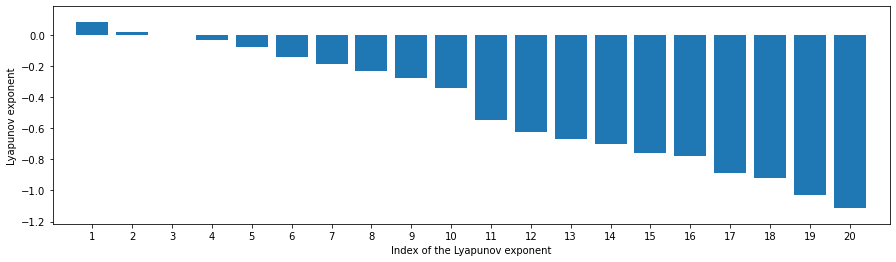

In [17]:
plt.figure(figsize=(15, 4))

mean_exp = np.mean(bexp, axis=-1) / model_parameters.dimensional_time

x_pos = np.arange(1.,model_parameters.ndim+1,1)

plt.bar(x_pos, mean_exp)

plt.xticks(x_pos, map(str,range(1, model_parameters.ndim+1,1)))

plt.xlim(x_pos[0]-1., x_pos[-1]+1.)
plt.ylim(np.min(mean_exp)-0.1, np.max(mean_exp)+0.1)

plt.ylabel("Lyapunov exponent");
plt.xlabel("Index of the Lyapunov exponent");

First exponent:

In [18]:
mean_exp[0]

0.08201449048453724

Lyapunov time:

In [19]:
1/mean_exp[0]

12.19296729263394

## Optional exercise: Computing the full spectrum of a land-atmosphere coupled system

Use the [following example notebook](https://github.com/Climdyn/qgs/blob/master/notebooks/ground_heat.ipynb) to learn how to setup a [land-atmosphere coupled model](https://qgs.readthedocs.io/en/latest/files/model/li_model.html) and compute its Lyapunov spectrum. Compare this spectrum to the previous one.

In [20]:
# Model parameters instantiation with some non-default specs
model_parameters = QgParams({'phi0_npi': np.deg2rad(50.)/np.pi, 'n':1.5})
# Mode truncation at the wavenumber 2 in both x and y spatial coordinate for the atmosphere
model_parameters.set_atmospheric_channel_fourier_modes(2, 2)
# Same modes for the ground temperature modes
model_parameters.set_ground_channel_fourier_modes()

# Changing (increasing) the orography depth
model_parameters.ground_params.set_orography(0.2, 1)
# Setting the parameters of the heat transfer from the soil
model_parameters.gotemperature_params.set_params({'gamma': 1.6e7})
model_parameters.atemperature_params.set_params({ 'hlambda': 10.})


In [21]:
model_parameters.atemperature_params.set_insolation(300*0.33, 0)
model_parameters.gotemperature_params.set_insolation(300, 0)

In [22]:
%%time
f, Df = create_tendencies(model_parameters)

CPU times: user 2.68 s, sys: 763 ms, total: 3.44 s
Wall time: 2.54 s


In [23]:
integrator.set_func(f)

Start on a random initial condition and integrate over a transient time to obtain an initial condition on the attractors

In [24]:
%%time
ic = np.random.rand(model_parameters.ndim)*0.1
integrator.integrate(0., 200000., dt, ic=ic, write_steps=0)
time, ic = integrator.get_trajectories()

CPU times: user 8.09 ms, sys: 34.5 ms, total: 42.6 ms
Wall time: 11.1 s


In [25]:
%%time

lvint.set_func(f, Df)
lvint.compute_lyapunovs(0., 10000., 20000., 0.1, 0.1, ic, write_steps=1)
btl, btraj, bexp, bvec = lvint.get_lyapunovs()

/scratch/jodemaey/projects/qgs_lyap_dev/qgs/toolbox/lyapunov.py:557: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  recorded_traj, recorded_exp, recorded_vec = _compute_backward_lyap_traj_jit(f, fjac, pretime, time, ttraj, mdt,
/scratch/jodemaey/projects/qgs_lyap_dev/qgs/toolbox/lyapunov.py:557: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  recorded_traj, recorded_exp, recorded_vec = _compute_backward_lyap_traj_jit(f, fjac, pretime, time, ttraj, mdt,
/scratch/jodemaey/projects/qgs_lyap_dev/qgs/toolbox/lyapunov.py:557: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  recorded_traj, recorded_exp, recorded_vec = _compute_backward_lyap_traj_jit(f, fjac, pretime, time, ttraj, mdt,
/scratch/jodemaey/projects/qgs_lyap_dev/qgs/toolbox/lyapunov.py:557: NumbaPerformanceWarning: '@'

CPU times: user 268 ms, sys: 3.42 s, total: 3.69 s
Wall time: 44.9 s


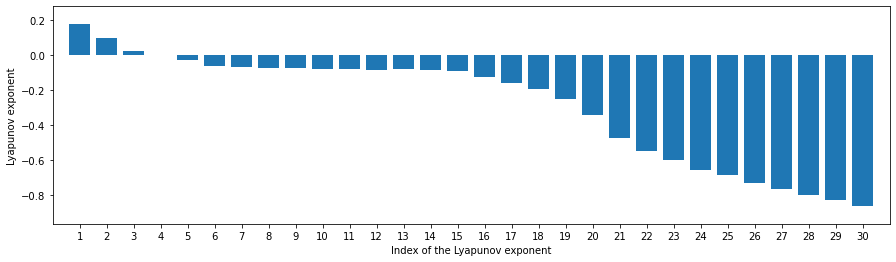

In [26]:
plt.figure(figsize=(15, 4))

mean_exp = np.mean(bexp, axis=-1) / model_parameters.dimensional_time

x_pos = np.arange(1.,model_parameters.ndim+1,1)

plt.bar(x_pos, mean_exp)

plt.xticks(x_pos, map(str,range(1, model_parameters.ndim+1,1)))

plt.xlim(x_pos[0]-1., x_pos[-1]+1.)
plt.ylim(np.min(mean_exp)-0.1, np.max(mean_exp)+0.1)

plt.ylabel("Lyapunov exponent");
plt.xlabel("Index of the Lyapunov exponent");

First exponent:

In [27]:
mean_exp[0]

0.17780311672447668

Lyapunov time:

In [28]:
1/mean_exp[0]

5.624198374146601

The End.